In [141]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import warnings
import spacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns

%matplotlib inline

warnings.filterwarnings("ignore")
SEED = 23

In [142]:
df = pd.read_csv('/Users/ira/Downloads/REALEC_Inspector/results/classification_dataset.csv')
df['class'] = round(df['class'] / 10).astype(int)
df = df[df['class'] != 1]
_type = df['type'].to_list()
df = df.drop(['name', 'side_mistake',
              'vs', 'squared_vs', 'ttr', 'root_ttr',
              'log_ttr', 'uber_ttr', 'd', 'vvi',
              'squared_vv', 'punct_mistakes_pp',
              'punct_mistakes_because',
              'punct_mistakes_but', 'punct_mistakes_compare'], axis=1)

df.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,5,1,0,0,2,0,This two line graphs illustrates monthly avera...,6,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,6,1,0,0,3,0,"﻿We have two graphics, which show us the popul...",6,1,0


In [143]:
import numpy as np
np.mean(df['ndw'].to_list())

114.00348837209302

In [144]:
df.describe()

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_past_simple,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,class,type,sum_punct
count,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,...,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.00000,3440.000000,3440.000000,3440.000000
mean,4.656041,7.965988,2.255523,3.824419,2.472093,4.723547,12.496221,256.715407,5.987265,21.487808,...,3.999709,11.784012,6.250291,1.238372,1.972384,2.561337,0.25843,5.960756,1.506105,0.966570
std,0.877185,2.025931,1.080692,2.795437,2.220036,3.454691,4.497292,77.811645,2.022516,5.172961,...,3.408890,6.832915,5.443343,1.505301,2.066668,2.368806,1.11784,0.728217,0.500035,1.274159
min,1.880000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,17.000000,1.000000,7.180000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,1.000000,0.000000
25%,4.050000,7.000000,2.000000,2.000000,1.000000,2.000000,9.000000,193.000000,4.650000,18.000000,...,1.000000,6.000000,2.000000,0.000000,0.000000,1.000000,0.00000,6.000000,1.000000,0.000000
50%,4.570000,8.000000,2.000000,3.000000,2.000000,4.000000,12.000000,250.000000,5.660000,20.790000,...,3.000000,11.000000,5.000000,1.000000,1.000000,2.000000,0.00000,6.000000,2.000000,1.000000
75%,5.180000,9.000000,3.000000,5.000000,4.000000,7.000000,15.000000,308.250000,6.955000,24.180000,...,6.000000,16.000000,9.000000,2.000000,3.000000,4.000000,0.00000,6.000000,2.000000,1.000000
max,10.000000,26.000000,7.000000,20.000000,18.000000,22.000000,40.000000,647.000000,20.250000,61.570000,...,19.000000,45.000000,41.000000,13.000000,14.000000,19.000000,14.00000,8.000000,2.000000,9.000000


In [145]:
# df = pd.read_csv('/Users/ira/Downloads/REALEC_Inspector/results/train.csv')
# df.head(2)

In [146]:
# train, test = train_test_split(df, test_size=0.3, shuffle=True, random_state=SEED)
# train.to_csv('/Users/ira/Downloads/REALEC_Inspector/results/train.csv', index=False)
# test.to_csv('/Users/ira/Downloads/REALEC_Inspector/results/test.csv', index=False)

In [147]:
df.shape

(3440, 62)

In [148]:
df['class'].value_counts()

6    2680
7     308
5     215
4     122
8      77
2      24
3      14
Name: class, dtype: int64

In [153]:
for x in df[df['class'] == 4].iloc[0].to_list():
    print(x)

5.0
9
3
0
2
4
5
134
5.8
26.8
17
12
5
3
8
4
13
0
1
22.75
23.23
27.98
27.25
0.51
0.09
0.35
0.69
0.12
0.04
0.15
87
5.31
0.65
2.83
0.24
0.16
0.16
0.13
0.29
0.03
0.14
0.2
0.0
2.5
0.38
0.75
7
1
3
0
2
4
7
8
2
3
1
0
It is well-known fact, that musical industry is one of the most popular industry among modern society, Many people in the music business fell that illegal music sites on the Internet are a serious threat to the industry and many people suggest that people, who use illegal files should be punished, but some people do not agree.  

There are those why strongly convinced that publishing music illegally will result in death of this field. Because musicians could not get supported financially in order to produse more art work. This issue, for instance, is more pressing in countes which do not obey copyright. I suppose, these illegal activities will affect musicians’ personal lives due to their low incomes and investments. 

4
2
1


In [115]:
# test = pd.read_csv('/Users/ira/Downloads/REALEC_Inspector/results/test.csv')
# test.shape

In [116]:
# test['class'].value_counts()

In [117]:
# sns.set(rc={'figure.figsize':(20,10)})
# sns_plt = sns.countplot(x='class', data=test, palette="Set2")
# sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/multiclass_distribution_test.png')

# Multiclass

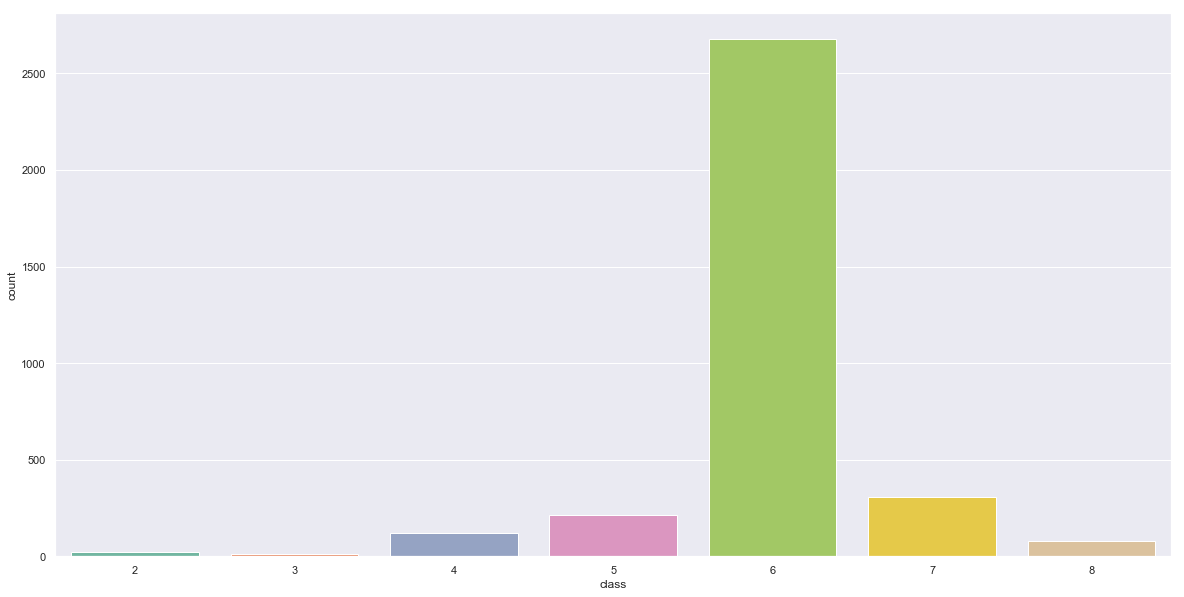

In [118]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='class', data=df, palette="Set2")
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/multiclass_distribution.png')

In [119]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[feature_columns]
y = df['class']

In [120]:
get_numeric_data = FunctionTransformer(lambda x: x[feature_columns], validate=False)

def build_model(classifier):
    model = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data)
            ]))
        ])),
        ('clf', classifier)
    ])
    return model

In [121]:
sns.set(rc={'figure.figsize':(8, 4)})
def get_info(classifier, X, y, classes, plot_matrix=False):
    model = build_model(classifier=classifier)
    y_pred = cross_val_predict(model, X, y, cv=10)
    print(classification_report(y, y_pred))
    if plot_matrix:
        conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
        sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                              yticklabels=classes,
                              xticklabels=classes)

              precision    recall  f1-score   support

           2       0.33      0.25      0.29        24
           3       0.00      0.00      0.00        14
           4       0.50      0.25      0.34       122
           5       0.15      0.05      0.08       215
           6       0.80      0.97      0.88      2680
           7       0.26      0.05      0.08       308
           8       0.00      0.00      0.00        77

   micro avg       0.77      0.77      0.77      3440
   macro avg       0.29      0.22      0.24      3440
weighted avg       0.68      0.77      0.71      3440



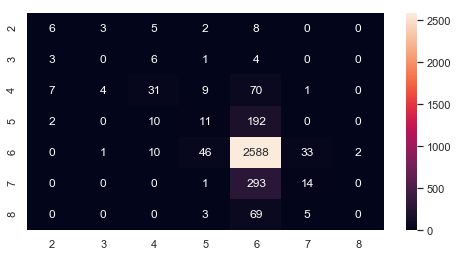

In [122]:
get_info(KNeighborsClassifier(), X, y, classes=set(df['class']), plot_matrix=True)

              precision    recall  f1-score   support

           2       0.07      0.33      0.12        24
           3       0.07      0.21      0.11        14
           4       0.23      0.29      0.26       122
           5       0.19      0.09      0.12       215
           6       0.83      0.84      0.84      2680
           7       0.28      0.15      0.20       308
           8       0.06      0.13      0.08        77

   micro avg       0.69      0.69      0.69      3440
   macro avg       0.25      0.29      0.25      3440
weighted avg       0.70      0.69      0.69      3440



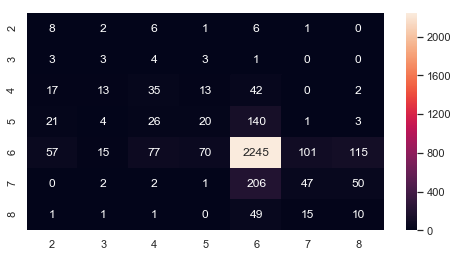

In [123]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X, y, classes=set(df['class']), plot_matrix=True)

# Binary classification

In [124]:
targets = []
for t in df['class']:
    if int(t) >= 7:
        targets.append('best')
    else:
        targets.append('non-best')
df['class'] = targets

In [140]:
df

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,5,1,0,0,2,0,This two line graphs illustrates monthly avera...,non-best,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,6,1,0,0,3,0,"﻿We have two graphics, which show us the popul...",non-best,1,0
2,3.81,6,0,5,0,13,16,292,4.56,18.25,...,13,5,2,1,1,0,More and more young people are stunding on the...,non-best,2,1
3,4.33,7,2,3,3,6,12,221,6.67,18.42,...,16,9,3,0,4,0,﻿Nowdays we can notice the tendency that large...,non-best,2,2
4,4.25,5,3,2,3,0,8,160,7.12,20.00,...,8,0,0,2,3,0,The graph gives information about level of une...,non-best,1,1
5,3.89,5,2,0,0,1,9,212,6.78,23.56,...,4,3,1,0,4,0,"In Africa unemployment reached its peak of 12,...",non-best,1,1
6,3.91,6,2,5,1,1,11,196,5.64,17.82,...,6,8,2,0,0,0,The pie charts represent two ways of transport...,non-best,1,1
7,3.88,6,1,3,2,3,16,273,3.38,17.06,...,13,7,3,3,5,0,I will try to describe this situation from bot...,non-best,2,2
8,5.17,10,0,3,6,9,18,389,5.33,21.61,...,30,7,2,0,2,0,﻿In this day and age we can observe such situa...,non-best,2,0
9,5.12,8,3,0,2,7,16,408,5.44,25.50,...,13,22,3,2,3,0,"﻿Nowadays, a lot of scientists work on the spa...",best,2,2


In [139]:
for x in df[df['class'] == 'best'].iloc[0].to_list():
    print(x)

5.12
8
3
0
2
7
16
408
5.44
25.5
36
24
12
5
29
16
34
1
1
24.47
22.39
28.18
29.8
0.46
0.06
0.12
0.73
0.11
0.03
0.13
165
5.78
0.4
2.62
0.11
0.12
0.18
0.11
0.29
0.04
0.18
0.11
0.06
3.5
0.41
0.78
14
5
19
0
2
3
13
22
3
2
3
0
﻿Nowadays, a lot of scientists work on the space exploration problem. Governments of many countries spend enormous amount of money on relevant researches, whereas a lot of other problems, such as poverty, hunger or environmental issues are still not solved. So, it is not surprising that many people think that spending money on space exploration is pointless and it would be better to work on solving more urgent problems in society.

I believe that it is a quite fair opinion. Firstly, it is not smart to spend a huge part of country's budget on space exploration when the economic situation in your country is not very stable. For example, in the last three years Russia did a few unsuccessful experiments with cargo spacecrafts (one of them was "Progress"). These failures cost

In [130]:
df_good = df[df['class'] == 'best']
df_not_good = df[df['class'] != 'best']

In [135]:
for f in [x for x in df.columns if x not in ['class', 'type', 'text']]:
    good = round(df_good[f].mean(), 2)
    bad = round(df_not_good[f].mean(), 2)
    print(f'{f},{good},{bad}')

av_depth,5.05,4.61
max_depth,8.69,7.88
min_depth,2.44,2.23
num_acl,5.22,3.65
num_rel_cl,3.2,2.38
num_advcl,6.29,4.53
num_sent,13.0,12.43
num_tok,296.11,251.75
av_tok_before_root,6.4,5.94
av_len_sent,23.72,21.21
num_cl,25.19,22.29
num_tu,16.19,15.56
num_compl_tu,9.0,6.73
num_coord,6.69,6.03
num_poss,16.85,14.53
num_prep,14.85,12.58
num_adj_noun,17.95,14.45
num_part_noun,3.25,2.2
num_noun_inf,2.3,1.71
pos_sim_nei,19.83,17.81
pos_sim_all,20.36,18.3
lemma_sim_all,26.45,23.55
lemma_sim_nei,25.8,22.96
density,0.45,0.44
ls,0.12,0.13
corrected_vs,0.31,0.28
lfp_1000,0.68,0.67
lfp_2000,0.1,0.1
lfp_uwl,0.04,0.04
lfp_rest,0.18,0.2
ndw,131.64,111.78
corrected_ttr,5.38,4.96
lv,0.45,0.45
corrected_vv,2.82,2.48
vvii,0.16,0.16
nv,0.13,0.13
adjv,0.13,0.13
advv,0.1,0.09
modv,0.23,0.22
der_level3,0.05,0.04
der_level4,0.07,0.08
der_level5,0.06,0.05
der_level6,0.04,0.04
mci,4.15,3.39
freq_finite_forms,0.37,0.42
freq_aux,0.61,0.64
num_inf,11.51,9.45
num_gerunds,3.42,2.33
num_pres_sing,9.1,7.21
num_pres_plur,

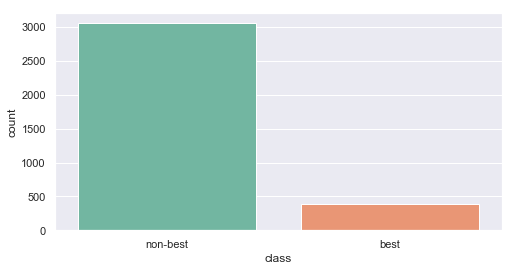

In [52]:
sns_plt = sns.countplot(x='class', data=df, palette="Set2")
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/binary_class_distribution.png')

In [53]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[feature_columns]
y = df['class']

## LogisticRegression

In [54]:
sns.set(rc={'figure.figsize':(5, 3)})

In [55]:
def get_info(classifier, X, y, classes=['non_best', 'best']):
    model = build_model(classifier=classifier)
    y_pred = cross_val_predict(model, X, y, cv=10)
    print(classification_report(y, y_pred))
    conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
    sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                          yticklabels=classes,
                          xticklabels=classes)

              precision    recall  f1-score   support

        best       0.23      0.67      0.35       385
    non-best       0.95      0.72      0.82      3055

   micro avg       0.72      0.72      0.72      3440
   macro avg       0.59      0.70      0.58      3440
weighted avg       0.87      0.72      0.77      3440



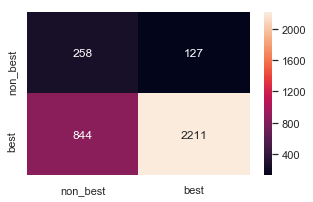

In [56]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X, y)

## RandomForestClassifier

              precision    recall  f1-score   support

        best       0.60      0.06      0.12       385
    non-best       0.89      0.99      0.94      3055

   micro avg       0.89      0.89      0.89      3440
   macro avg       0.74      0.53      0.53      3440
weighted avg       0.86      0.89      0.85      3440



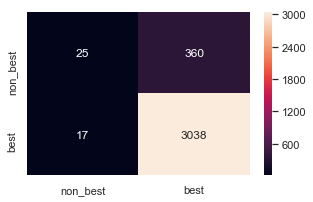

In [57]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X, y)

## KNeighborsClassifier

              precision    recall  f1-score   support

        best       0.32      0.08      0.13       385
    non-best       0.89      0.98      0.93      3055

   micro avg       0.88      0.88      0.88      3440
   macro avg       0.61      0.53      0.53      3440
weighted avg       0.83      0.88      0.84      3440



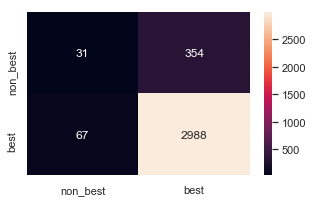

In [58]:
get_info(KNeighborsClassifier(), X, y)

# Balance class: Python imbalanced-learn module
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

## Undersampling

In [59]:
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)
X_rus = pd.DataFrame(X_rus, columns=feature_columns)

### LogisticRegression

              precision    recall  f1-score   support

        best       0.68      0.64      0.66       385
    non-best       0.66      0.69      0.68       385

   micro avg       0.67      0.67      0.67       770
   macro avg       0.67      0.67      0.67       770
weighted avg       0.67      0.67      0.67       770



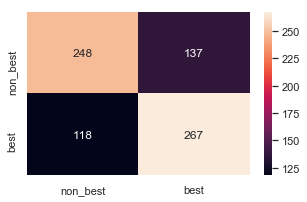

In [60]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X_rus, y_rus)

### RandomForestClassifier

              precision    recall  f1-score   support

        best       0.66      0.67      0.67       385
    non-best       0.67      0.65      0.66       385

   micro avg       0.66      0.66      0.66       770
   macro avg       0.66      0.66      0.66       770
weighted avg       0.66      0.66      0.66       770



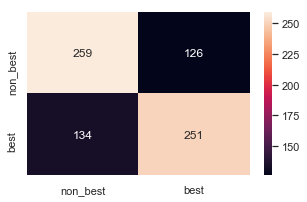

In [61]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X_rus, y_rus)

### KNeighborsClassifier

              precision    recall  f1-score   support

        best       0.59      0.62      0.60       385
    non-best       0.60      0.58      0.59       385

   micro avg       0.60      0.60      0.60       770
   macro avg       0.60      0.60      0.60       770
weighted avg       0.60      0.60      0.60       770



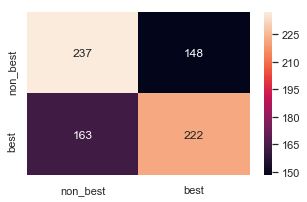

In [62]:
get_info(KNeighborsClassifier(), X_rus, y_rus)

## Oversampling

In [63]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)
X_ros = pd.DataFrame(X_ros, columns=feature_columns)

### LogisticRegression

              precision    recall  f1-score   support

        best       0.71      0.72      0.72      3055
    non-best       0.72      0.71      0.71      3055

   micro avg       0.72      0.72      0.72      6110
   macro avg       0.72      0.72      0.72      6110
weighted avg       0.72      0.72      0.72      6110



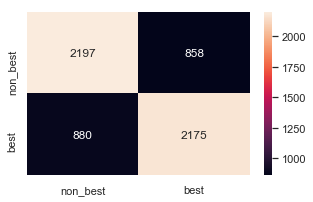

In [64]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X_ros, y_ros)

### RandomForestClassifier

              precision    recall  f1-score   support

        best       0.98      1.00      0.99      3055
    non-best       1.00      0.98      0.99      3055

   micro avg       0.99      0.99      0.99      6110
   macro avg       0.99      0.99      0.99      6110
weighted avg       0.99      0.99      0.99      6110



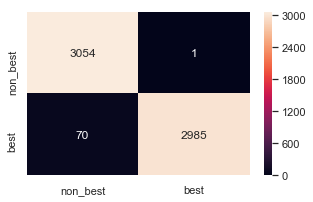

In [65]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X_ros, y_ros)

### KNeighborsClassifier

              precision    recall  f1-score   support

        best       0.79      0.99      0.88      3055
    non-best       0.99      0.74      0.84      3055

   micro avg       0.86      0.86      0.86      6110
   macro avg       0.89      0.86      0.86      6110
weighted avg       0.89      0.86      0.86      6110



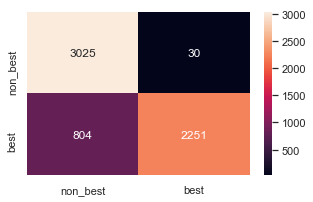

In [66]:
get_info(KNeighborsClassifier(), X_ros, y_ros)

# Type prediction

In [67]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'type']]
X = df[feature_columns]
y = df['type']

In [84]:
get_numeric_data = FunctionTransformer(lambda x: x[numeric_columns], validate=False)
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatizer(text):
    lemmas = nlp(text)
    return [token.lemma_ for token in lemmas]

tf_idf = TfidfVectorizer(tokenizer=lemmatizer)



def build_model(classifier):
    model = Pipeline([
        ('features', FeatureUnion([
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vectorizer', tf_idf)
            ]))
        ])),
        ('clf', classifier)
    ])
    return model

In [71]:
model = build_model(classifier=RandomForestClassifier(class_weight='balanced',
                                                  random_state=SEED))
y_pred = cross_val_predict(model, X, y, cv=10)

In [72]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1699
           2       1.00      1.00      1.00      1741

   micro avg       1.00      1.00      1.00      3440
   macro avg       1.00      1.00      1.00      3440
weighted avg       1.00      1.00      1.00      3440



In [14]:
df_1 = df[df['type'] == 1]
df_2 = df[df['type'] == 2]

In [15]:
X = df_1[feature_columns]
y = df_1['class']
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)
X_rus = pd.DataFrame(X_rus, columns=feature_columns)

In [73]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X_rus, y_rus, classes=['best', 'non-best'])

KeyError: 'text'

              precision    recall  f1-score   support

        best       0.67      0.73      0.70       118
    not_best       0.70      0.64      0.67       118

   micro avg       0.68      0.68      0.68       236
   macro avg       0.68      0.68      0.68       236
weighted avg       0.68      0.68      0.68       236



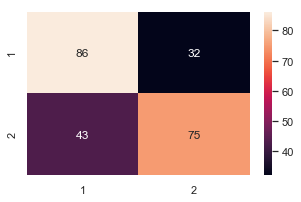

In [17]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X_rus, y_rus, classes=['1', '2'])

              precision    recall  f1-score   support

        best       0.60      0.62      0.61       118
    not_best       0.61      0.59      0.60       118

   micro avg       0.61      0.61      0.61       236
   macro avg       0.61      0.61      0.61       236
weighted avg       0.61      0.61      0.61       236



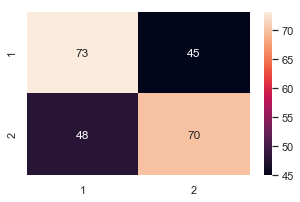

In [18]:
get_info(KNeighborsClassifier(), X_rus, y_rus, classes=['1', '2'])

In [19]:
X = df_2[feature_columns]
y = df_2['class']
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)
X_rus = pd.DataFrame(X_rus, columns=feature_columns)

              precision    recall  f1-score   support

        best       0.67      0.68      0.67       142
    not_best       0.67      0.66      0.67       142

   micro avg       0.67      0.67      0.67       284
   macro avg       0.67      0.67      0.67       284
weighted avg       0.67      0.67      0.67       284



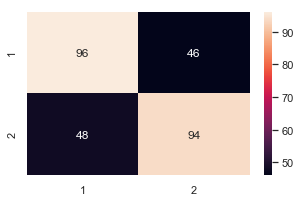

In [20]:
get_info(LogisticRegression(class_weight='balanced', random_state=SEED), X_rus, y_rus, classes=['1', '2'])

              precision    recall  f1-score   support

        best       0.69      0.70      0.70       142
    not_best       0.70      0.69      0.70       142

   micro avg       0.70      0.70      0.70       284
   macro avg       0.70      0.70      0.70       284
weighted avg       0.70      0.70      0.70       284



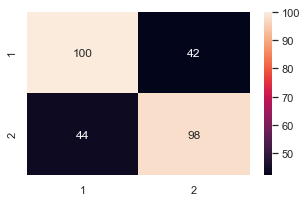

In [21]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X_rus, y_rus, classes=['1', '2'])

              precision    recall  f1-score   support

        best       0.62      0.61      0.62       142
    not_best       0.62      0.63      0.62       142

   micro avg       0.62      0.62      0.62       284
   macro avg       0.62      0.62      0.62       284
weighted avg       0.62      0.62      0.62       284



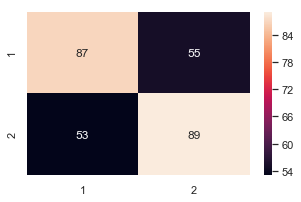

In [22]:
get_info(KNeighborsClassifier(), X_rus, y_rus, classes=['1', '2'])

# TF_IDF

In [21]:
get_numeric_data = FunctionTransformer(lambda x: x[numeric_columns], validate=False)
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatizer(text):
    lemmas = nlp(text)
    return [token.lemma_ for token in lemmas]

tf_idf = TfidfVectorizer(tokenizer=lemmatizer)



def build_model(classifier):
    model = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data)
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vectorizer', tf_idf)
            ]))
        ])),
        ('clf', classifier)
    ])
    return model

In [31]:
numeric_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[numeric_columns + ['text']]
y = df['class']

In [32]:
model = build_model(classifier=LogisticRegression(class_weight='balanced',
                                                  random_state=SEED))
y_pred = cross_val_predict(model, X, y, cv=10)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

        best       0.34      0.67      0.45       260
    not_best       0.95      0.84      0.89      2148

   micro avg       0.82      0.82      0.82      2408
   macro avg       0.65      0.76      0.67      2408
weighted avg       0.89      0.82      0.85      2408



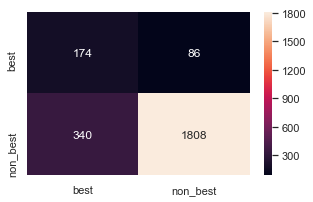

In [33]:
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                      yticklabels=['best', 'non_best'],
                      xticklabels=['best', 'non_best'])

In [34]:
model = build_model(classifier=RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED))
y_pred = cross_val_predict(model, X, y, cv=10)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

        best       0.93      0.05      0.09       260
    not_best       0.90      1.00      0.95      2148

   micro avg       0.90      0.90      0.90      2408
   macro avg       0.91      0.52      0.52      2408
weighted avg       0.90      0.90      0.85      2408



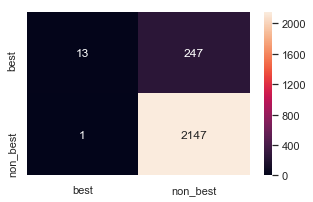

In [35]:
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                      yticklabels=['best', 'non_best'],
                      xticklabels=['best', 'non_best'])

In [36]:
model = build_model(classifier=KNeighborsClassifier())
y_pred = cross_val_predict(model, X, y, cv=10)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

        best       0.38      0.09      0.15       260
    not_best       0.90      0.98      0.94      2148

   micro avg       0.89      0.89      0.89      2408
   macro avg       0.64      0.54      0.54      2408
weighted avg       0.84      0.89      0.85      2408



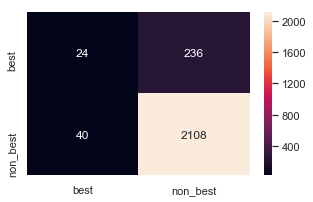

In [37]:
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                      yticklabels=['best', 'non_best'],
                      xticklabels=['best', 'non_best'])

## Undersampling

In [41]:
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)
X_rus = pd.DataFrame(X_rus, columns=numeric_columns + ['text'])
X_rus[numeric_columns] = X_rus[numeric_columns].apply(pd.to_numeric)
X_rus['text'] = X_rus['text'].apply(str)

In [42]:
model = build_model(classifier=LogisticRegression(class_weight='balanced',
                                                  random_state=SEED))
y_pred = cross_val_predict(model, X_rus, y_rus, cv=10)
print(classification_report(y_rus, y_pred))

              precision    recall  f1-score   support

        best       0.74      0.70      0.72       260
    not_best       0.71      0.75      0.73       260

   micro avg       0.72      0.72      0.73       520
   macro avg       0.73      0.72      0.72       520
weighted avg       0.73      0.72      0.72       520



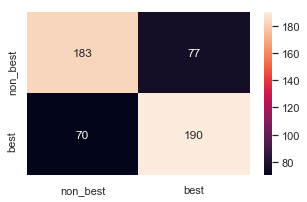

In [29]:
conf_mat = confusion_matrix(y_true=y_rus, y_pred=y_pred)
sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                      yticklabels=['non_best', 'best'],
                      xticklabels=['non_best', 'best'])

In [32]:
model = build_model(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED))
y_pred = cross_val_predict(model, X_rus, y_rus, cv=10)
print(classification_report(y_rus, y_pred))

              precision    recall  f1-score   support

        best       0.72      0.70      0.71       260
    not_best       0.71      0.72      0.72       260

   micro avg       0.71      0.71      0.71       520
   macro avg       0.71      0.71      0.71       520
weighted avg       0.71      0.71      0.71       520



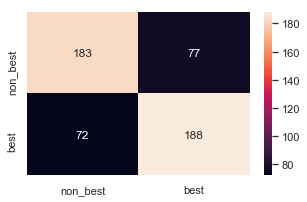

In [33]:
conf_mat = confusion_matrix(y_true=y_rus, y_pred=y_pred)
sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                      yticklabels=['non_best', 'best'],
                      xticklabels=['non_best', 'best'])

In [30]:
model = build_model(KNeighborsClassifier())
y_pred = cross_val_predict(model, X_rus, y_rus, cv=10)
print(classification_report(y_rus, y_pred))

              precision    recall  f1-score   support

        best       0.62      0.65      0.63       260
    not_best       0.63      0.60      0.62       260

   micro avg       0.62      0.62      0.62       520
   macro avg       0.63      0.62      0.62       520
weighted avg       0.63      0.62      0.62       520



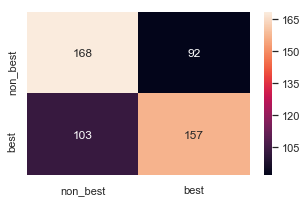

In [31]:
conf_mat = confusion_matrix(y_true=y_rus, y_pred=y_pred)
sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                      yticklabels=['non_best', 'best'],
                      xticklabels=['non_best', 'best'])

# Best model on test sample

In [86]:
df = pd.read_csv('/Users/ira/Downloads/REALEC_Inspector/results/classification_dataset.csv')
df['class'] = round(df['class'] / 10).astype(int)
df = df[df['class'] != 1]
_type = df['type'].to_list()
df = df.drop(['name', 'side_mistake',
              'vs', 'squared_vs', 'ttr', 'root_ttr',
              'log_ttr', 'uber_ttr', 'd', 'vvi',
              'squared_vv', 'punct_mistakes_pp',
              'punct_mistakes_because',
              'punct_mistakes_but', 'punct_mistakes_compare'], axis=1)

df.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,5,1,0,0,2,0,This two line graphs illustrates monthly avera...,6,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,6,1,0,0,3,0,"﻿We have two graphics, which show us the popul...",6,1,0


In [87]:
targets = []
for t in df['class']:
    if int(t) >= 7:
        targets.append('best')
    else:
        targets.append('non-best')
df['class'] = targets

In [88]:
numeric_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X_test =df[numeric_columns + ['text']]
y_test = df['class']
model = build_model(classifier=RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED))

In [89]:
def get_info(classifier, X, y, classes, plot_matrix=False):
    model = build_model(classifier=classifier)
    y_pred = cross_val_predict(model, X, y, cv=10)
    print(classification_report(y, y_pred))
    if plot_matrix:
        conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
        sns_plt = sns.heatmap(conf_mat, annot=True, fmt="d",
                              yticklabels=classes,
                              xticklabels=classes)

              precision    recall  f1-score   support

        best       0.50      0.05      0.09       385
    non-best       0.89      0.99      0.94      3055

   micro avg       0.89      0.89      0.89      3440
   macro avg       0.70      0.52      0.52      3440
weighted avg       0.85      0.89      0.85      3440



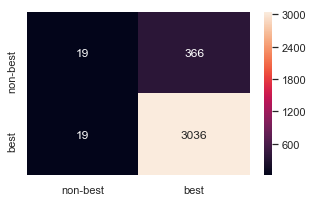

In [90]:
get_info(RandomForestClassifier(n_estimators=50,
                                max_depth= 20,
                                class_weight='balanced',
                                random_state=SEED), X_test, y_test, ['non-best', 'best'], plot_matrix=True)

In [ ]:
y_pred = cross_val_predict(model, X_rus, y_rus, cv=10)
print(classification_report(y_rus, y_pred))

In [42]:
model.fit(X, y)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x134771598>, inv_kw_args=None,
          inverse_func=None, kw...mators=50, n_jobs=None, oob_score=False, random_state=23,
            verbose=0, warm_start=False))])

In [43]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        best       1.00      0.03      0.06       124
    not_best       0.88      1.00      0.94       909

   micro avg       0.88      0.88      0.88      1033
   macro avg       0.94      0.52      0.50      1033
weighted avg       0.90      0.88      0.83      1033

